<a href="https://colab.research.google.com/github/PDamaral/Projects/blob/main/Previs%C3%A3o_Agravamento_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREDIÇÃO DO AGRAVAMENTO DE SAUDE DO PACIENTE COM COVID-19**

# Contextualização

São Paulo 19 de fevereiro de 2021

No início de 2020 o mundo se deparou com o inicio de uma pandemia como nenhuma outra registrada em tempos modernos, o vírus denominado SARS-CoV-2 ou COVID-19 como passou a ser chamado tomou os países de surpresa graças ao seu rápido contagio.

No final de fevereiro o Brasil confirma seu primeira caso, sendo na cidade de São Paulo, e desse período ate os dias atuais tivemos um grande aumento dos casos e dos óbitos gerados por esse vírus.

Um grave problema e a lotação dos hospitais e dos leitos de UTI, levando assim ao colapso do sistema de saúde, o que nos leva ao porque deste estudo.

A equipe do Hospital Sírio Libanês, criou um chamado a ação para que especialista em dados criem um modelo de predição, com alta taxa de precisão para que analisando os dados de um paciente internado seja possível dizer se o caso dele ira se agravar e que ele vá ser internado na UTI posteriormente.

Este estudo aborda o uso de técnicas de aprendizado de maquina para que analisando os dados cedidos pela equipe do Hospital consigamos realizar esta previsão.


Setup do projeto
 - instalação de bibliotecas
 - importação de bibliotecas
 - criação de funções

In [ ]:
pip install boruta

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
def primeira_janela(paciente):
  if(np.any(paciente['ICU'])):
    paciente.loc[paciente['WINDOW'] == '0-2',"ICU"] = 1
  return paciente.loc[paciente['WINDOW'] =='0-2']

## Analise do historico de casos nos estados de São Paulo e Distrito Federal

In [ ]:
casos_raw = pd.read_csv('/content/drive/MyDrive/Data science/Alura bootcamp/Desafios/Desafio 6/covid19-BrasilIO20022021.csv')
casos_raw.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2021-02-19,AC,NaN,state,54562,951,True,894470,12,6099.92510,0.0174
1,2021-02-19,AL,NaN,state,127341,2913,True,3351543,27,3799.47385,0.0229
2,2021-02-19,AM,NaN,state,303586,10359,True,4207714,13,7214.98657,0.0341
3,2021-02-19,AP,NaN,state,81689,1121,True,861773,16,9479.17839,0.0137
4,2021-02-19,BA,NaN,state,647384,11060,True,14930634,29,4335.94447,0.0171


In [ ]:
casos = casos_raw.drop(['city','place_type', 'deaths', 'estimated_population','city_ibge_code','confirmed_per_100k_inhabitants','death_rate','is_last'], axis =1)
casos = casos.set_index('state')
casos = casos.pivot_table(values="confirmed", index="date", columns="state")
casos = casos.fillna(method='ffill')
casos = casos.fillna(0)
casos_sp = pd.DataFrame(casos['SP'])
casos_sp['Media_casos'] = casos_sp["SP"].rolling(7).mean().fillna(0)
casos_sp['Crescimento'] = casos_sp['SP'] - casos_sp['SP'].shift()
casos_sp['Media_crescimento'] = casos_sp["Crescimento"].rolling(7).mean().fillna(0)
casos_df = pd.DataFrame(casos['DF'])
casos_df['Media_casos'] = casos_df["DF"].rolling(7).mean().fillna(0)
casos_df['Crescimento'] = casos_df['DF'] - casos_df['DF'].shift()
casos_df['Media_crescimento'] = casos_df["Crescimento"].rolling(7).mean().fillna(0)

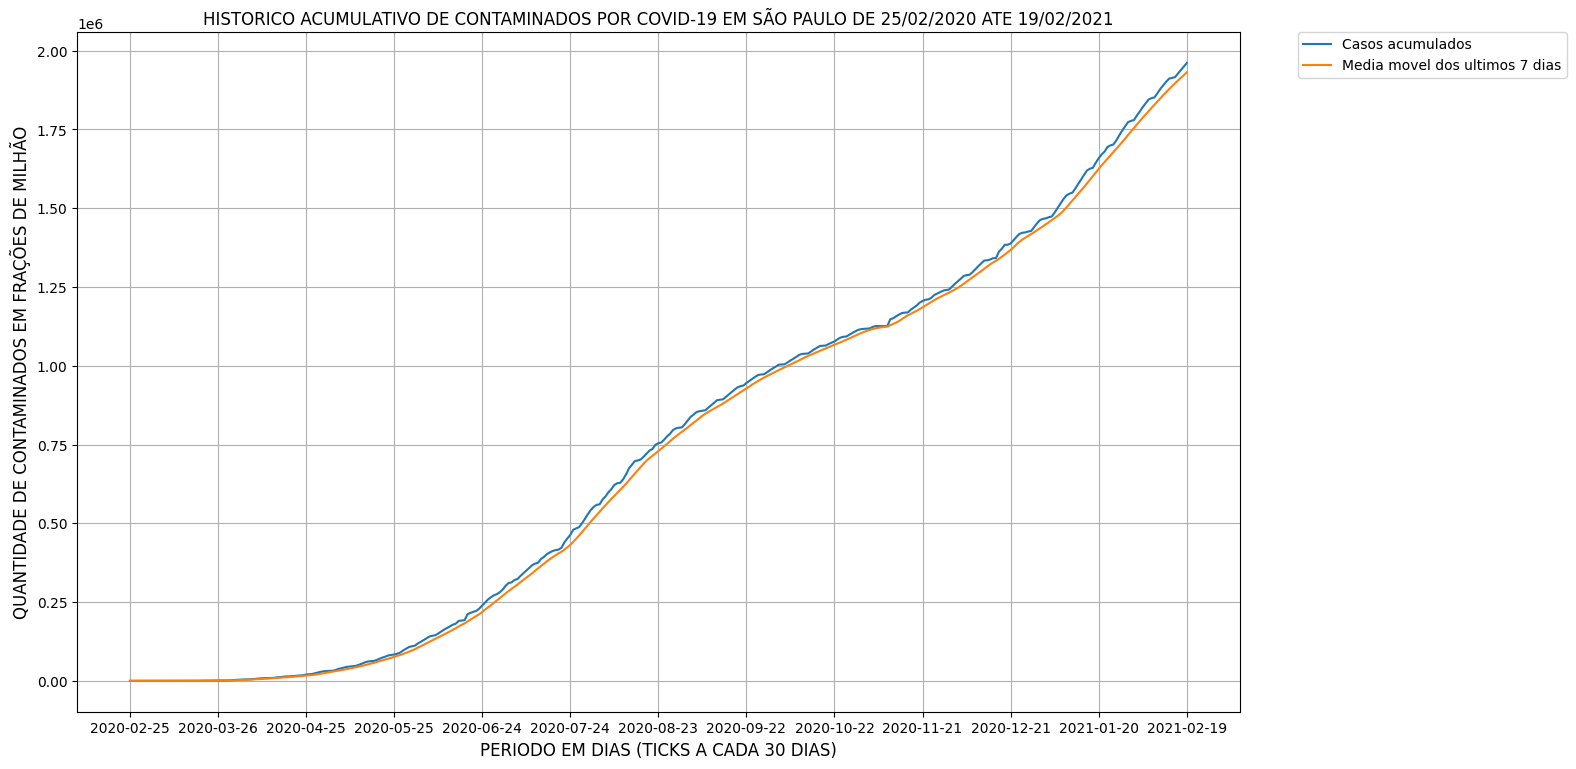

In [ ]:
%matplotlib inline

plt.figure(figsize=(15,9), dpi=100)

plt.xticks(ticks=np.arange(0,361, step=30), fontsize=10)

plt.title('HISTORICO ACUMULATIVO DE CONTAMINADOS POR COVID-19 EM SÃO PAULO DE 25/02/2020 ATE 19/02/2021')  
plt.xlabel('PERIODO EM DIAS (TICKS A CADA 30 DIAS)',fontsize=12)
plt.ylabel('QUANTIDADE DE CONTAMINADOS EM FRAÇÕES DE MILHÃO', fontsize=12)
plt.grid()

plt.plot(casos_sp[['SP','Media_casos']])

plt.legend(['Casos acumulados', 'Media movel dos ultimos 7 dias'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

In [ ]:
fig = go.Figure(data=[
  go.Bar(name='Novos casos', x=casos_sp.index, y=casos_sp['Crescimento']),
  go.Bar(name='Media dos ultimos 7 dias de novos casos', x=casos_sp.index, y=casos_sp['Media_crescimento'])
])

fig.update_xaxes(title_text= 'PERIODO EM DIAS')
fig.update_yaxes(title_text= 'QUANTIDADE NOVOS CASOS')

fig.update_layout(title='HISTORICO DE NOVOS CASOS POR DIA PDE COVID-19 EM SÃO PAULO DE 25/02/2020 ATE 19/02/2021')
fig.update_layout(template='seaborn',width=1700,xaxis=dict(mirror=True,linewidth=2,linecolor='black',showgrid=True),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='black'))

fig.update_layout(barmode='group')
fig.show()

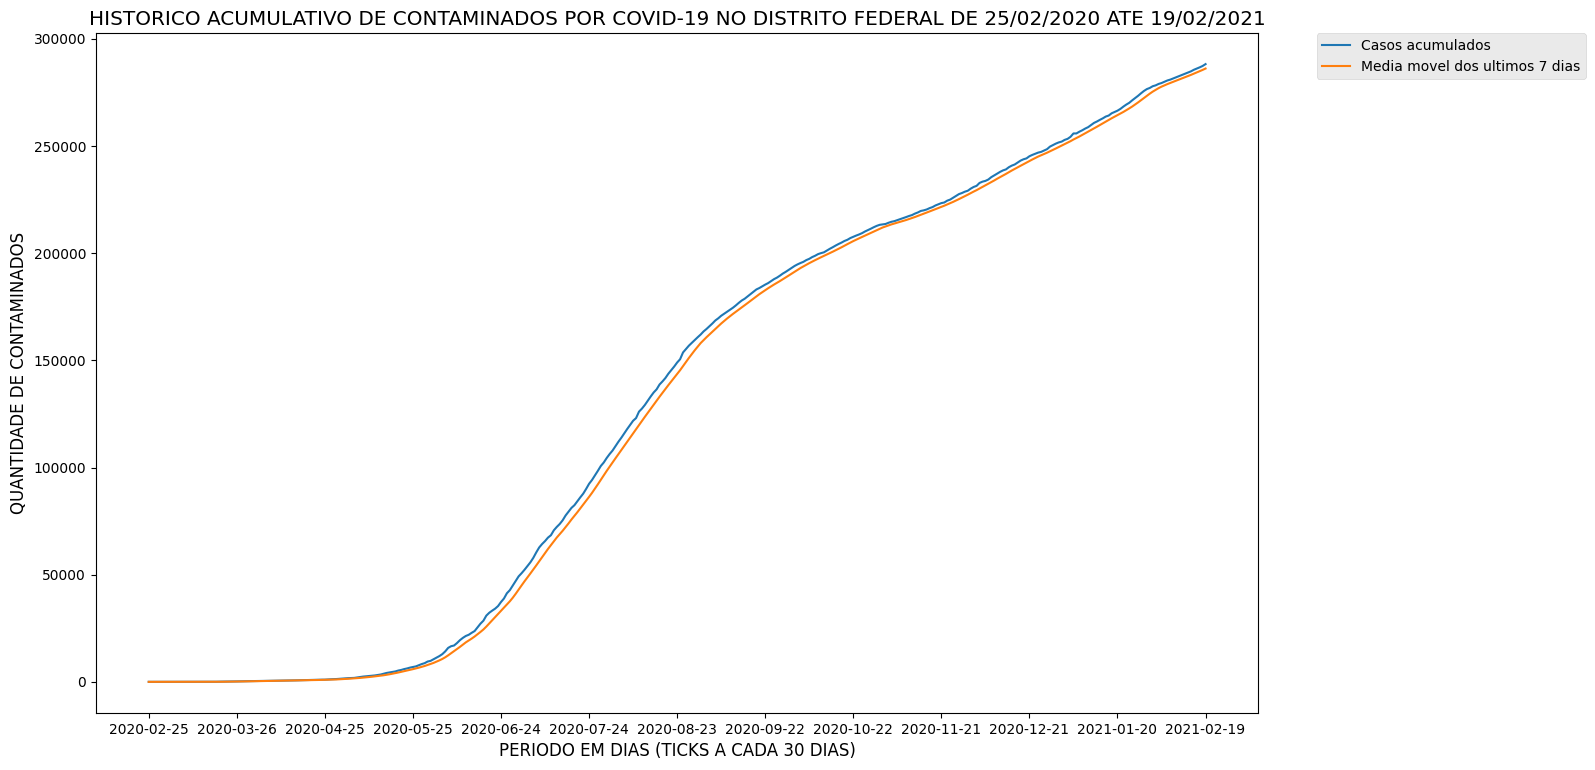

In [ ]:
%matplotlib inline

plt.figure(figsize=(15,9), dpi=100)
plt.xticks(ticks=np.arange(0,361, step=30), fontsize=10)

plt.style.use('ggplot')

plt.title('HISTORICO ACUMULATIVO DE CONTAMINADOS POR COVID-19 NO DISTRITO FEDERAL DE 25/02/2020 ATE 19/02/2021')  
plt.xlabel('PERIODO EM DIAS (TICKS A CADA 30 DIAS)',fontsize=12)
plt.ylabel('QUANTIDADE DE CONTAMINADOS', fontsize=12)

#plt.grid()

plt.plot(casos_df[['DF','Media_casos']])

plt.legend(['Casos acumulados', 'Media movel dos ultimos 7 dias'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

In [ ]:
fig = go.Figure(data=[
  go.Bar(name='Novos casos', x=casos_df.index, y=casos_df['Crescimento']),
  go.Bar(name='Media dos ultimos 7 dias de novos casos', x=casos_df.index, y=casos_df['Media_crescimento'])
])

fig.update_xaxes(title_text= 'PERIODO EM DIAS')
fig.update_yaxes(title_text= 'QUANTIDADE NOVOS CASOS')

fig.update_layout(title='HISTORICO DE NOVOS CASOS POR DIA PDE COVID-19 NO DISTRITO FEDERAL DE 25/02/2020 ATE 19/02/2021')
fig.update_layout(template='ggplot2',width=1700,xaxis=dict(mirror=True,linewidth=2,linecolor='black',showgrid=True),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='black'))

fig.update_layout(barmode='group')
fig.show()

Podemos observar o rápido crescimento e como foram os números da primeira ‘onda’ de infecções e que estamos aparentemente no pico da segunda ‘onda’.

# Desafio proposto

Iremos analisar o dataset fornecido pela equipe do Hospital Sírio Libanês, com dados anonimizados. O modelo segue as regras:
- A feature ‘ICU’ denomina se o paciente foi transferido para a UTI.
- Todos os dados de quando o paciente foi a UTI não devem ser usados, devido a não precisão da tomada dos mesmos, podendo comprometer a fidelidade do modelo.
- Os dados foram agrupados em janelas de tempo na feature ‘Window’, onde são 5 janelas de tempo medidas em horas.

A estratégia para o modelo será utilizar apenas a primeira janela de tempo para realizar a predição, pois o quanto antes for tomada a decisão melhor pode ser o atendimento e a preparação da equipe medica.

Nos próximos passos será realizada a analise exploratória dos dados, seguindo os passos aqui comentados.


In [ ]:
#importação da base de dados
raw = pd.read_excel("/content/drive/MyDrive/Data science/Alura bootcamp/Desafios/Desafio 6/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
raw.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
#Tamanho e quantidade de features do dataset
raw.shape

(1925, 231)

In [ ]:
#Descrição para melhor entendimento das features
raw.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

## Celulas sem valor

Como orientação da equipe do Hospital, todas as celulas sem valores foram preenchidas com os valores seguintes do mesmo paciente, desde que o mesmo esteja estavel (não ingressou na UTI na proxima janela).



In [ ]:
print(f'A base de dados apresenta {raw.isna().sum().sum()} campos sem valor')

A base de dados apresenta 223863 campos sem valor


In [ ]:
df_internacao = raw.fillna(method='bfill')
print(f'A base de dados apresenta {df_internacao.isna().sum().sum()} campos sem valor')

A base de dados apresenta 0 campos sem valor


In [ ]:
df_internacao.shape

(1925, 231)

In [ ]:
df_internacao

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

## Seleção de janela

Rotina para selecionar apenas a primeira janela de cada paciente, e identificar se em alguma janela posterior o mesmo foi a UTI (alterando o valor da feature ICU).

In [ ]:
df_internacao_primeirajanela = df_internacao.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
df_internacao_primeirajanela

array([  1,  17,  27,  41,  47,  48,  54,  62,  85,  90, 104, 106, 109,
       117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306,
       315, 329, 359, 362, 366, 379])

In [ ]:
df_internacao = df_internacao.query('PATIENT_VISIT_IDENTIFIER not in @df_internacao_primeirajanela')
df_internacao

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

In [ ]:
df_internacao = df_internacao.groupby('PATIENT_VISIT_IDENTIFIER').apply(primeira_janela).set_index('PATIENT_VISIT_IDENTIFIER').reset_index()
df_internacao

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-

## Adição de medidas biologicas recomendadas

Adicionando features biologicas recomendadas pela equipe do Hospital

In [ ]:
df_internacao["BLOODPRESSURE_ARTERIAL_MEAN"] = (df_internacao['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df_internacao['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
df_internacao["NEUTROPHILES/LINFOCITOS"] = df_internacao['NEUTROPHILES_MEAN']/df_internacao['LINFOCITOS_MEAN']
df_internacao["GASO"] = df_internacao.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
df_internacao["GASO"] = (~df_internacao["GASO"].isna()).astype(int)
df_internacao

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,GASO
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1,-0.019310,0.949515,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1,-0.554965,0.454450,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,-0.114846,0.938541,1
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.88366

## Criação de dataset somente com variaveis biologicas

Criando um Dataset somente com as features consideradas interessantes do ponto de vista biológico pela equipe do hospital.


In [ ]:
df_bio = df_internacao[["ICU","PATIENT_VISIT_IDENTIFIER","AGE_ABOVE65","GENDER","BLOODPRESSURE_ARTERIAL_MEAN","RESPIRATORY_RATE_MAX","HTN",'DISEASE GROUPING 1','DISEASE GROUPING 2',
               'DISEASE GROUPING 3','DISEASE GROUPING 4','DISEASE GROUPING 5','DISEASE GROUPING 6',"GASO","OXYGEN_SATURATION_MIN","HEART_RATE_MAX","PCR_MEAN","CREATININ_MEAN"]]
df_bio.head()

,ICU,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,BLOODPRESSURE_ARTERIAL_MEAN,RESPIRATORY_RATE_MAX,HTN,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,GASO,OXYGEN_SATURATION_MIN,HEART_RATE_MAX,PCR_MEAN,CREATININ_MEAN
0,1,0,1,0,-0.019310,-0.636364,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0.898990,-0.432836,-0.875236,-0.868365
1,1,2,0,0,-0.554965,-0.575758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.959596,0.000000,-0.939887,-0.912243
2,0,3,0,1,-0.114846,-0.515152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.878788,-0.626866,-0.503592,-0.968861
3,0,4,0,0,0.170940,-0.575758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.939394,-0.044776,-0.990926,-0.913659
4,0,5,0,0,-0.204179,-0.575758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.919192,-0.626866,-0.997732,-0.891012


## Seleção de features utilizando BORUTA

Utilizando a técnica BORUTA para a seleção das features mais importante para o treinamento dos modelos.


O BORUTA simula valores aleatórios de cada feature, chamadas de shadows criando um dataframe novo, aplica o modelo de arvore de decisão avaliando cada modelo por N vezes, no nosso caso são 50 vezes(50 iterações), como resultado nos traz features em 3 areas, vermelha que são descartadas, azul que podem ou não entrar no modelo(em nosso caso optamos por adota-las, devido a quantidade de features nessa zona) e verde onde são as features com mais impacto ao modelo.


In [ ]:
df_internacao = df_internacao.T.drop_duplicates().T
df_internacao = df_internacao.drop(columns=['AGE_PERCENTIL','WINDOW'])
df_internacao

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,HEMOGLOBIN_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,NEUTROPHILES_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,...,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,GASO
0,0,1,0,0,0,0,0,1,1,0,0,1,0.605263,-1,-1,-1,-0.317073,-0.317073,-0.93895,-1,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.0901468,0.109756,-0.932246,1,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,...,0.0864198,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.0864198,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0,-0.162393,-0.5,0.208791,0.89899,-0.247863,-0.459459,-0.432836,-0.636364,-0.42029,0.736842,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-0.0193099,0.949515,1
1,2,0,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1,-1,-0.317073,-0.317073,-0.93895,-1,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,...,-0.489712,-0.68547,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.0566038,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0,-0.575758,0.101449,1,-0.547826,-0.533742,-0.603053,-0.764706,-1,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1,-0.961262,1,-0.554965,0.45445,1
2,3,0,1,0,0,0,0,0,0,0,1,1,-0.263158,-1,-1,-1,-0.317073,-0.317073,-0.972789,-1,0.326531,-0.968861,-0.19403,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.8361,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,...,0.0123457,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.0123457,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.42029,0.684211,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-0.114846,0.938541,1
3,4,0,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1,-1,-0.317073,-0.317073,-0.935113,-1,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1,-0.702202,-0.641079,-0.812725,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,...,0.333333,-0.153846,0.160377,-0.59322,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0,0.196581,-0.571429,0.538462,0.939394,-0.0769231,-0.351351,-0.0447761,-0.575758,0.0724638,0.894737,-1,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,0.17094,1.26775,1
4,5,0,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1,-1,-0.317073,-0.317073,-0.93895,-1,0.357143,-0.891012,-0.742004,-0.958528,-0.8

In [ ]:
X = df_internacao.drop(columns=['ICU'])
Y = df_internacao['ICU']

In [ ]:
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)

In [ ]:
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 50
)

In [ ]:
boruta.fit(np.array(X), np.array(Y))

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=5,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=105, n_jobs=-1,
                                         oob_score=False,
                                         random_state=RandomState(MT19937) at 0x7FBE737A1270,
                                         verbose=0, warm_start=False),
         max_iter=50, n_estimators='auto', perc=100,
         random_stat

In [ ]:
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

In [ ]:
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['AGE_ABOVE65', 'CREATININ_MEDIAN', 'GLUCOSE_MEDIAN', 'PCR_MEDIAN', 'SODIUM_MEDIAN', 'UREA_MEDIAN', 'RESPIRATORY_RATE_MEAN', 'NEUTROPHILES/LINFOCITOS']
features in the blue area: ['LINFOCITOS_MEDIAN', 'NEUTROPHILES_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN']


In [ ]:
df_boruta = df_internacao[['ICU','AGE_ABOVE65', 'CREATININ_MEDIAN', 'PCR_MEDIAN', 'SODIUM_MEDIAN', 'UREA_MEDIAN', 'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'NEUTROPHILES/LINFOCITOS',
                           'GLUCOSE_MEDIAN', 'LINFOCITOS_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN']]
df_boruta

,ICU,AGE_ABOVE65,CREATININ_MEDIAN,PCR_MEDIAN,SODIUM_MEDIAN,UREA_MEDIAN,RESPIRATORY_RATE_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,NEUTROPHILES/LINFOCITOS,GLUCOSE_MEDIAN,LINFOCITOS_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,RESPIRATORY_RATE_MEDIAN
0,1,1,-0.868365,-0.875236,-0.0285714,-0.836145,-0.59322,0.0864198,0.949515,-0.891993,-0.914938,0.0864198,-0.586207
1,1,0,-0.912243,-0.939887,0.0857143,-0.836145,-0.645951,-0.506173,0.45445,-0.780261,-0.908714,-0.506173,-0.517241
2,0,0,-0.968861,-0.503592,0.2,-0.937349,-0.457627,0.0123457,0.938541,-0.891993,-0.8361,0.0123457,-0.448276
3,0,0,-0.913659,-0.990926,0.142857,-0.903614,-0.59322,0.333333,1.26775,-0.851024,-0.641079,0.333333,-0.586207
4,0,0,-0.891012,-0.997732,0.0857143,-0.884337,-0.525424,-0.037037,2.48741,-0.891993,-0.340249,-0.037037,-0.517241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1,0,-0.937721,-0.565974,-0.428571,-0.860241,-0.457627,-0.160494,0.851571,-0.824953,-0.879668,-0.160494,-0.448276
349,0,1,-0.886766,-0.993195,-0.314286,-0.855422,-0.457627,-0.407407,0.905741,-0.891993,-0.921162,-0.407407,-0.448276
350,1,0,-0.905166,-0.0344045,-0.0857143,-0.787952,-0.457627,0.0123457,0.894205,-0.891993,-0.838174,0.0123457,-0.448276
351,0,0,-0.922151,-0.804159,0.0857143,-0.937349,-0.661017,0.0864198,1.11429,-0.843575,-0.819502,0.0864198,-0.655172


Abaixo temos uma comparação das features selecionadas pelo BORUTA com as features de interesse biológico.

In [ ]:
df_boruta.columns

Index(['ICU', 'AGE_ABOVE65', 'CREATININ_MEDIAN', 'PCR_MEDIAN', 'SODIUM_MEDIAN',
       'UREA_MEDIAN', 'RESPIRATORY_RATE_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'NEUTROPHILES/LINFOCITOS',
       'GLUCOSE_MEDIAN', 'LINFOCITOS_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN'],
      dtype='object')

In [ ]:
df_bio.columns

Index(['ICU', 'PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER',
       'BLOODPRESSURE_ARTERIAL_MEAN', 'RESPIRATORY_RATE_MAX', 'HTN',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
       'GASO', 'OXYGEN_SATURATION_MIN', 'HEART_RATE_MAX', 'PCR_MEAN',
       'CREATININ_MEAN'],
      dtype='object')

# Modelo de predição


Utilizaremos 3 técnicas para a predição eles são:

Regressão Logistica (logistic regression)

Classificador de Floresta Aleatoria(Random Forest Classifier)

Maquina de vetores de suporte (SVM)


O foco da resposta de cada modelo sera a metrica RECALL, onde quanto menor ela for, maior a chance da classificação de um falso negativo, ou seja o paciente não e esperado que va para a UTI porem seu estado piora e isso acaba acontecendo. 

Outro ponto de analise e a matriz de confusão, sendo abaixo uma legenda, o sendo os pontos verdadeiros os acertos e o falsos os erros, o modelo com menor valor no Falso negativo sera escolhido (quadrante superior direito).

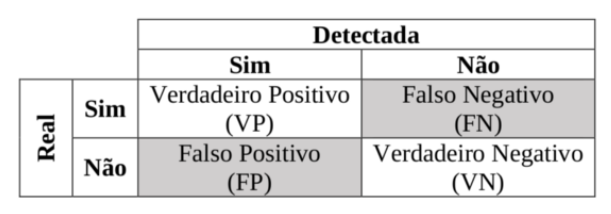

Sera aplicado cada modelo em ambos os datasets (selecionados com o Boruta e medidas biologicas)

Por possuirmos poucos dados separamos apenas 15% do modelo para validação e 85% para testes.

## Regressão Logistica com data set - BORUTA

In [ ]:
x_boruta= df_boruta.drop(columns=['ICU'])
y_boruta= df_boruta['ICU'].astype(int)

In [ ]:
x_boruta_treino, x_boruta_teste, y_boruta_treino, y_boruta_teste = train_test_split(x_boruta,y_boruta, test_size=0.15, random_state=13428, stratify=y_boruta)

In [ ]:
regressão_logistica_boruta = LogisticRegression(random_state=13428, max_iter=500)

In [ ]:
regressão_logistica_boruta.fit(x_boruta_treino, y_boruta_treino)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13428, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_boruta_pred_reg = regressão_logistica_boruta.predict(x_boruta_teste)

In [ ]:
print(classification_report(y_boruta_teste,y_boruta_pred_reg))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.82      0.75      0.78        24

    accuracy                           0.81        53
   macro avg       0.81      0.81      0.81        53
weighted avg       0.81      0.81      0.81        53



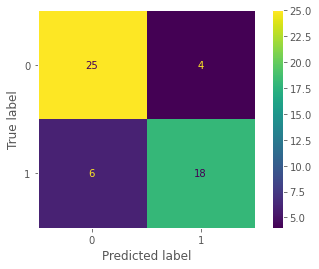

In [ ]:
plot_confusion_matrix(regressão_logistica_boruta, x_boruta_teste, y_boruta_teste)
plt.grid(False)
plt.show()

## Regressão Logistica com data set - Biologicas

In [ ]:
x_bio= df_boruta.drop(columns=['ICU'])
y_bio= df_boruta['ICU'].astype(int)

In [ ]:
x_bio_treino, x_bio_teste, y_bio_treino, y_bio_teste = train_test_split(x_bio,y_bio, test_size=0.15, random_state=13428, stratify=y_bio)

In [ ]:
regressão_logistica_bio = LogisticRegression(random_state=13428, max_iter=500)

In [ ]:
regressão_logistica_bio.fit(x_bio_treino, y_bio_treino)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13428, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_bio_pred = regressão_logistica_bio.predict(x_bio_teste)

In [ ]:
print(classification_report(y_bio_teste,y_bio_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.82      0.75      0.78        24

    accuracy                           0.81        53
   macro avg       0.81      0.81      0.81        53
weighted avg       0.81      0.81      0.81        53



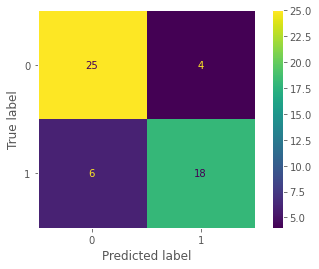

In [ ]:
plot_confusion_matrix(regressão_logistica_bio, x_bio_teste, y_bio_teste)
plt.grid(False)
plt.show()

## Random forest Classifier - BORUTA

In [ ]:
classificador_floresta_boruta = RandomForestClassifier(random_state=13428)

In [ ]:
classificador_floresta_boruta.fit(x_boruta_treino, y_boruta_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=13428,
                       verbose=0, warm_start=False)

In [ ]:
y_boruta_pred = classificador_floresta_boruta.predict(x_boruta_teste)

In [ ]:
print(classification_report(y_boruta_teste,y_boruta_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.75      0.75      0.75        24

    accuracy                           0.77        53
   macro avg       0.77      0.77      0.77        53
weighted avg       0.77      0.77      0.77        53



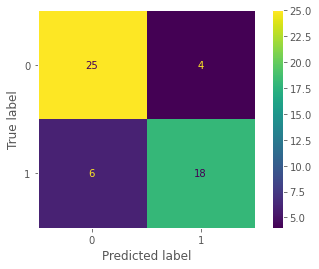

In [ ]:
plot_confusion_matrix(regressão_logistica_boruta, x_boruta_teste, y_boruta_teste)
plt.grid(False)
plt.show()

## Random forest Classifier - Biologicas


In [ ]:
classificador_floresta_bio = RandomForestClassifier(random_state=13428)

In [ ]:
classificador_floresta_bio.fit(x_bio_treino, y_bio_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=13428,
                       verbose=0, warm_start=False)

In [ ]:
y_bio_pred = classificador_floresta_bio.predict(x_bio_teste)

In [ ]:
print(classification_report(y_bio_teste,y_bio_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.75      0.75      0.75        24

    accuracy                           0.77        53
   macro avg       0.77      0.77      0.77        53
weighted avg       0.77      0.77      0.77        53



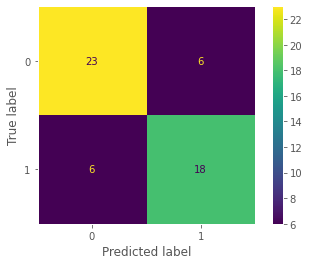

In [ ]:
plot_confusion_matrix(classificador_floresta_bio, x_bio_teste, y_bio_teste)
plt.grid(False)
plt.show()

## SVM - BORUTA

In [ ]:
svm_boruta = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [ ]:
svm_boruta.fit(x_boruta_treino, y_boruta_treino)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
y_boruta_pred = svm_boruta.predict(x_boruta_teste)

In [ ]:
print(classification_report(y_boruta_teste,y_boruta_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.77      0.71      0.74        24

    accuracy                           0.77        53
   macro avg       0.77      0.77      0.77        53
weighted avg       0.77      0.77      0.77        53



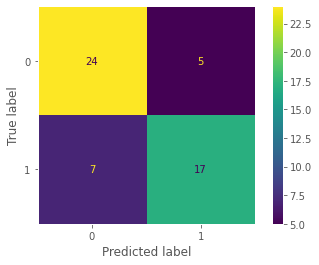

In [ ]:
plot_confusion_matrix(svm_boruta, x_boruta_teste, y_boruta_teste)
plt.grid(False)
plt.show()

## SVM - Biologicas

In [ ]:
svm_bio = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [ ]:
svm_bio.fit(x_bio_treino, y_bio_treino)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
y_bio_pred = svm_bio.predict(x_bio_teste)

In [ ]:
print(classification_report(y_bio_teste,y_bio_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.77      0.71      0.74        24

    accuracy                           0.77        53
   macro avg       0.77      0.77      0.77        53
weighted avg       0.77      0.77      0.77        53



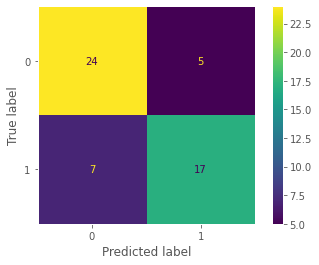

In [ ]:
plot_confusion_matrix(svm_bio, x_bio_teste, y_bio_teste)
plt.grid(False)
plt.show()

# Resultado e impacto

Obtivemos um resultado muito similar entre os datasets no modelo de regressão logística, com grau de precisão não muito alto (RECALL de 75%), porem acredito que este sistema deva ser um auxiliar a expertise do profissional de saúde, onde este conhece mais do que e possível passar a um dataset, portanto apresento a mudança da abordagem de apresentação do resultado do modelo, em vez de determinar se o paciente ira para a UTI, sera apresentada uma tabela com a chance do quadro do paciente se agravar, conforme tabela abaixo(utilizando as métricas do modelo de regressão logística com o dataset de features selecionada pelo boruta).

Onde cada celula representa a chance em percentual do paciente não ir a UTI.

In [ ]:
print(regressão_logistica_boruta.predict_proba(x_boruta_teste)[:,1])

[0.41000929 0.06511014 0.13795442 0.32904831 0.49483245 0.75750169
 0.15466588 0.32488099 0.21837509 0.64071684 0.67957796 0.20993111
 0.51717009 0.94338506 0.74911908 0.66627218 0.89089695 0.88728853
 0.83630534 0.5573659  0.22904923 0.33667359 0.29203468 0.2606087
 0.75452303 0.20954772 0.29864828 0.24279734 0.41338284 0.8689135
 0.90016141 0.90984963 0.28454421 0.33919093 0.80837445 0.42363581
 0.09120229 0.80428278 0.88919257 0.34648045 0.7177882  0.29851727
 0.40233514 0.40877074 0.70727926 0.26882188 0.58738463 0.29877144
 0.79746044 0.1816037  0.48803447 0.1464805  0.15264974]


Este e o projeto final do Bootcamp da Alura de 2020/2021, gostaria de agradecer a toda a equipe da Alura pelo excelente trabalho e orientação durante todo o curso, aos colegas que sempre foram muito prestativos e empolgados com os desafios propostos.
Muito obrigado a todos! 

Paulo Amaral
